# E commerce  Product( Fine Food ) Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

### Attribute Information:



*   Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
 * ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

Given Dataset consists of reviews of fine foods from E_commerce Website . Reviews describe (1)product and user information, (2)ratings, and (3) a plain text review.Here, Logistic Regression algorithm is applied on amazon reviews datasets to predict whether a review is positive or negative.

Procedure to execute the above task is as follows:

* Step1: Data Pre-processing is applied on given amazon reviews data-set.And Take sample of data from dataset because of computational limitations
* Step2: Time based splitting on train and test datasets.
* Step3: Apply Feature generation techniques(Bow,tfidf)
* Step4: Apply Logistic Regression algorithm using each technique.
* Step5: To find lambda using gridsearch cross-validation and random cross-validation
* Step5: L2 regularization

* Step6: Feature Importance for postive and Negative reviews

         1. Most Important Feature
         2. Bar plot of top 15 Important Features.

## Objective:

##### To classify given reviews (positive (Rating of 4 or 5) & negative (rating of 1 or 2)) using Logistic regression algorithm

In [0]:

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"priyag143","key":"43c67edc4267d99dcc27bd143c23ccc6"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# reading zip file
import zipfile
with zipfile.ZipFile("amazon-fine-food-reviews.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [0]:
pip install pytablewriter

In [0]:

# All necessary module
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#import  sys
import re
import math
import sqlite3
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pytablewriter

from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

# modules for text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# knn modules
# train-split data,accuracy-score,cross-validation modules

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

In [0]:
import pandas as pd
amz=pd.read_csv('data/Reviews.csv')
print(amz.head())

   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]


In [0]:
print(amz.shape) 
#print(amz1.shape)
print(amz.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


reviews datafile contains 568454 rows of entry and 10 columns.For given objective, processing of data is necessary."Score" and "text" columns is processed for required result.

Given reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating. If score is equal to 3,it is considered as neutral score.

In [0]:
# Processing
#Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def score_part(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = amz['Score']
#print(actualScore)
New_score = actualScore.map(score_part)
#print(New_score)
amz['Score']=New_score

# If score is equal to 3,it is considered as neutral score.

In [0]:
print(amz['Score'][0:10])
print(amz.shape)
amz.head(5)

0    positive
1    negative
2    positive
3    negative
4    positive
5    positive
6    positive
7    positive
8    positive
9    positive
Name: Score, dtype: object
(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Pre-processing on raw data:
Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.

In [0]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#sorted_data.head() # printing sorted data
# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(5))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

            Id  ...                                               Text
171222  171223  ...  Freeze dried liver has a hypnotic effect on do...
171153  171154  ...  Freeze dried liver has a hypnotic effect on do...
171151  171152  ...  Freeze dried liver has a hypnotic effect on do...
217443  217444  ...  My dog can't resist these treats - I can get h...
217444  217445  ...  My little pupster loves these things. She is n...

[5 rows x 10 columns]
(393931, 10)


positive    336824
negative     57107
Name: Score, dtype: int64

List of total counts Postive score and Negative score ==> [336824, 57107]


Text(0.5, 1.0, 'Total counts of Postive score and Negative score ')

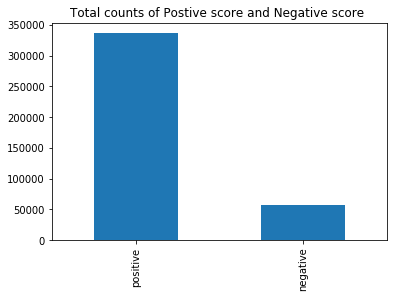

In [0]:

a=final['Score'].value_counts().tolist()
print('List of total counts Postive score and Negative score ==>',a)
final['Score'].value_counts().plot(kind='bar')
plt.title('Total counts of Postive score and Negative score ')

## observations
The positive reviews is greater than negative reviews.It makes data imbalanced.
From the bar plot ,it is seen that sampled datasets of review is imbalnced

# Text Preprocessing

Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.<br />All the flavor u want and no mater how much or fast u eat no brain frezze.<br />I found it best when its cold out side i can still have my icecream and not fell like im frezzing.<br />Its a great value price /per product. And has a long shelf life making it a good survival snack.
My cat loves these bubbles. All I have to say is "Do you want bubbles?" and

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In JuneI saw a charming groupof roses all beginto droopI pepped them upwith chicken soup!Sprinkle oncesprinkle twicesprinkle chicken soupwith riceThis is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.All the flavor u want and no mater how much or fast u eat no brain frezze.I found it best when its cold out side i can still have my icecream and not fell like im frezzing.Its a great value price /per product. And has a long shelf life making it a good survival snack.
My cat loves these bubbles. All I have to say is "Do you want bubbles?" and she comes running out from wherever she may be hiding. She meows and pounces on the

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My cat loves these bubbles. All I have to say is "Do you want bubbles?" and she comes running out from wherever she may be hiding. She meows and pounces on the bubbles. I am giving them a rating of 4 though because they smell horrible. If they drip on anything white it will turn green, but can easily be cleaned with some water and a sponge!!!!


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My cat loves these bubbles All I have to say is Do you want bubbles and she comes running out from wherever she may be hiding She meows and pounces on the bubbles I am giving them a rating of 4 though because they smell horrible If they drip on anything white it will turn green but can easily be cleaned with some water and a sponge 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 393931/393931 [02:06<00:00, 3111.84it/s]


In [0]:
final['CleanedText']=preprocessed_reviews
#adding a column of CleanedText which displays the data after pre-processing of the review 
Pre_Process_Data = final[['CleanedText','Score','Time']] 

X_Text=Pre_Process_Data ['CleanedText']

Y_Score =Pre_Process_Data ['Score'] # positive or negative score
print('\nPre_Process_Text_Data  X_Text=',X_Text.shape)
print('\nPre_Process_Score_Data Y_Score=',Y_Score.shape)


Pre_Process_Text_Data  X_Text= (393931,)

Pre_Process_Score_Data Y_Score= (393931,)


In [0]:
# postive and negtive reviews from original datasets of amazon
pos_final = Pre_Process_Data[Pre_Process_Data .Score == 'positive']# postive reviews
pos_final = pos_final.sample(frac=0.3)
print(pos_final.Score.value_counts())

neg_final = Pre_Process_Data [Pre_Process_Data .Score == 'negative'] # negative reviews
print(neg_final.Score.value_counts())

positive    101047
Name: Score, dtype: int64
negative    57107
Name: Score, dtype: int64


In [0]:
final_pos_neg = pd.concat([pos_final,neg_final],axis=0)
print(len(final_pos_neg))
print(type(final_pos_neg))

158154
<class 'pandas.core.frame.DataFrame'>


In [0]:
print(final_pos_neg.columns)

Index(['CleanedText', 'Score', 'Time'], dtype='object')


#### Unix timestamp
The column Time is based on unix timestamp.The unix time stamp is a way to track time as a running total of seconds and In time technically does not change no matter where you are located on the globe. This is very useful to computer systems for tracking and sorting dated information in dynamic and distributed applications both online and client side. https://www.unixtimestamp.com/

So here,time conversion is not necessary to process on amazon data.But following code will describe the date and time for human consideration.Time data is arranged according to year-month-day-hours-minute-seconds in descending order .

# Splitting Training and Testing dataset based on Time

In [0]:
# splitting training and testing dataset (Time based splitting)

#final_pos_neg= final_pos_neg.sample(frac=0.07,random_state=1)
X1 = final_pos_neg[['CleanedText','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#50k data sample
X=X1[:40000]
print(X.shape)
Y1 = final_pos_neg[['Score','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#50k data sample
Y=Y1[:40000]
Y = Y['Score'].map(lambda x: 1 if x == 'positive' else 0).values
print(Y.shape)
## 70 % of data
tt =math.ceil(len(X)*.7)
print(tt)

X_train_data =  X[:tt] 
X_train_data  = X_train_data
print('X_train_data ',X_train_data.shape)
X_test_data = X[tt:]
X_test_data = X_test_data
print('X_test_data ',X_test_data.shape )
Y_train_data = Y[:tt]
Y_train_data  = Y_train_data
print('Y_train_data ',Y_train_data.shape )
Y_test_data = Y[tt:]
Y_test_data= Y_test_data
print('Y_test_data ',Y_test_data .shape)

(40000, 1)
(40000,)
28000
X_train_data  (28000, 1)
X_test_data  (12000, 1)
Y_train_data  (28000,)
Y_test_data  (12000,)


# Optimal Lambda for Logistic Regression

In [0]:
models_performence = {
    'Model':[],
    'Vectorizer': [],
    'SearchCV':[],
    'Scoring Metrics': [],
    'Train_model_score': [],
    'Test_model_score': [],
    'best panalty': [],
    'Best lambda':[],
}

columns = ["Model","Vectorizer","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
print(len(columns))
pd.DataFrame(models_performence, columns=columns)

8


,Model,Vectorizer,SearchCV,Scoring Metrics,Train_model_score,Test_model_score,best panalty,Best lambda


In [0]:
# Time seris splitting Cross-Validation
tscv = TimeSeriesSplit(n_splits=10)

In [0]:
#  lambda_LR is function to calculate the lambda value using'L2' for Logistic Regression
def lambda_LR1(X_train,y_train,X_test, y_test,vectorization):
    #  regularization penalty space
    penalty = ['l2']
    #  regularization hyperparameter distribution using uniform distribution
    C1 = uniform(loc=0, scale=4)
    C = np.logspace(0, 4, 10)
    #  hyperparameter options
    hp1 =dict(C=C, penalty=penalty)
    hp = dict(C=C1, penalty=penalty)
    # Scoring options
    d = ['accuracy','precision','recall','f1'] 
    
    for i in range(len(d)):
        models_performence['Model'].append('Logistic Regression')
        models_performence['Vectorizer'].append(vectorization)
        models_performence['SearchCV'].append('GridSearchCV')
        #print('for GridSearchCV') 
        p = d[i]
        models_performence['Scoring Metrics'].append(p)
        model1 = GridSearchCV(LogisticRegression(), hp1, scoring = p, cv=tscv,n_jobs= -1)
        best_model1=model1.fit(X_train, y_train)
        
        Test_model_score=model1.score(X_test, y_test)
        Train_model_score=model1.score(X_train, y_train)
        models_performence['Train_model_score'].append(Train_model_score.mean())
        models_performence['Test_model_score'].append(Test_model_score.mean())
        
        #Reg1=best_model1.best_estimator_.get_params()['penalty']
       
        models_performence['best panalty'].append('l2')
        optimal_l1=best_model1.best_estimator_.get_params()['C']
        
        models_performence['Best lambda'].append(optimal_l1)
        
        
        
        #print('For RandomsearchCV')
        models_performence['Model'].append('Logistic Regression')
        models_performence['Vectorizer'].append(vectorization)
        
        models_performence['SearchCV'].append('RandomsearchCV')
        
        model2 = RandomizedSearchCV(LogisticRegression(),hp,scoring = p, cv=tscv,n_jobs= -1)
        # Fit randomized search
        best_model2 = model2.fit(X_train,y_train)
        
        models_performence['Scoring Metrics'].append(p)
        #print(model2.best_estimator_)
        Test_model_score2=model2.score(X_test, y_test)
        Train_model_score=model2.score(X_train, y_train)
        models_performence['Train_model_score'].append(Train_model_score.mean())
       
        models_performence['Test_model_score'].append(Test_model_score2.mean())
        #Reg2=best_model2.best_estimator_.get_params()['penalty']
        
        models_performence['best panalty'].append('l2')
        optimal_l2=best_model2.best_estimator_.get_params()['C']
       
        
        models_performence['Best lambda'].append(optimal_l2)

## lambda_LR
lambda_LR is function to calculate the optimal lambda value for Logistic Regression.
GridsearchCV and RandomsearchCV method are used to obtain optimal lambda with L2 penality,different scoring options(e.g,accuracy,precision,recall and F1-score) and broad range of lambda.
Best parameter lambda and penalty for which model performs very well is obatained.

### Pandas dataframe to markdown Table format

In [0]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    #writer.table_name = name
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

### Methods to convert text into vector
Methods:

* Bag of Words

* Tf-idf

Using above four method is used to convert text to numeric vector

# 1. Bag of Words (BoW)

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.

The bag-of-words model is simple to understand and implement and has seen great success in problems such as language modeling and document classification.
What is a Bag-of-Words?
A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.

The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents.

A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words.
A measure of the presence of known words.
It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

The bag-of-words can be as simple or complex as you like. The complexity comes both in deciding how to design the vocabulary of known words (or tokens) and how to score the presence of known words.

### BOW for Training Data

In [0]:
count_vect = CountVectorizer() #in scikit-learn

In [0]:
#vector of train data
data = count_vect.fit_transform(X_train_data.values.astype('U').ravel())
data.get_shape()

final_data = StandardScaler(with_mean=False).fit_transform(data )
print(final_data.shape)

(28000, 32891)


### BOW for Testing Data

In [0]:
final_data1=count_vect.transform(X_test_data.values.ravel())
#print(final_data1)
final_data_test = StandardScaler(with_mean=False).fit_transform(final_data1)
print(final_data_test.shape)

(12000, 32891)


Featured data of Bag of words is Standardization (mean=0 and std.dev=1).

In [0]:
Train_data=Y_train_data
print(Train_data.shape)

(28000,)


## Optimal lambda using BOW (l2 regularization)

In [0]:
# To get optimal lambda using BOW

vectorization='BOW'
optimal_lambda = lambda_LR1(final_data ,Train_data,final_data_test,Y_test_data,vectorization )

In [0]:
columns = ["Model","Vectorizer","SearchCV", "Scoring Metrics","Train_model_score", "Test_model_score", "best panalty","Best lambda"]
print(len(columns))
df=pd.DataFrame(models_performence, columns=columns)

8


In [0]:
result_display(df)

|       Model       |Vectorizer|   SearchCV   |Scoring Metrics|Train_model_score|Test_model_score|best panalty|Best lambda|
|-------------------|----------|--------------|---------------|----------------:|---------------:|------------|----------:|
|Logistic Regression|BOW       |GridSearchCV  |accuracy       |           0.9988|          0.7954|l2          |      1.000|
|Logistic Regression|BOW       |RandomsearchCV|accuracy       |           0.9988|          0.7935|l2          |      1.464|
|Logistic Regression|BOW       |GridSearchCV  |precision      |           0.9983|          0.8430|l2          |      1.000|
|Logistic Regression|BOW       |RandomsearchCV|precision      |           0.9983|          0.8435|l2          |      0.712|
|Logistic Regression|BOW       |GridSearchCV  |recall         |           0.9999|          0.8558|l2          |      1.000|
|Logistic Regression|BOW       |RandomsearchCV|recall         |           0.9999|          0.8589|l2          |      0.535|
|Logisti

Above table describes the performance of model with different scoring techniques and regularization techniques with best Cross-validation search techniques.




### GridSearchCV with L2 regularization (BOW)

In [0]:
df=pd.DataFrame(models_performence, columns=columns)
zx=df[df['best panalty'] == 'l2']
zx=zx[zx['SearchCV']=='GridSearchCV']
zx= zx.ix[zx['Test_model_score'].idxmax()]
print(zx)
lambdax=zx['Best lambda']

best_panalty=zx['best panalty']

Scoring_Metrics =zx['Scoring Metrics']
SearchCV=zx['SearchCV']
#print(SearchCV)

Model                Logistic Regression
Vectorizer                           BOW
SearchCV                    GridSearchCV
Scoring Metrics                   recall
Train_model_score                0.99995
Test_model_score                0.855836
best panalty                          l2
Best lambda                            1
Name: 4, dtype: object


In [0]:
#Best lambda and best penalty
hp1=dict(C=[lambdax], penalty=[best_panalty])
LR =GridSearchCV(LogisticRegression(), hp1, scoring =Scoring_Metrics, cv=tscv)
LR.fit(final_data ,Train_data)

prediction1 = LR.predict(final_data_test)

In [0]:
#Training accuracy and training error
training_score=LR.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.999949634852682
training error is = 5.036514731804331e-05


In [0]:

# Testing Accuracy and testing error for LogisticRegression model

Testing_score=round(accuracy_score(Y_test_data ,prediction1),5)
print("Accuracy for Logistic Regression model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Logistic Regression model with Bag of words is = ",Testing_error)

Accuracy for Logistic Regression model with Bag of words is =  0.79542
Testing error for Logistic Regression model with Bag of words is =  0.20457999999999998


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction1,average='macro'),5)*100
recall = round(recall_score(Y_test_data,prediction1,average='macro'),5)*100
precision = round(precision_score(Y_test_data ,prediction1,average='macro'),5)*100

In [0]:
print(classification_report( Y_test_data,prediction1))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      3912
           1       0.84      0.86      0.85      8088

    accuracy                           0.80     12000
   macro avg       0.77      0.76      0.77     12000
weighted avg       0.79      0.80      0.79     12000



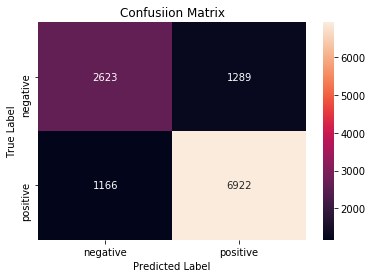

In [0]:
cm = confusion_matrix(Y_test_data ,prediction1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:

models_performence1 = {
    'Model':['Logistic Regression'],   
    'Vectorizer': ['BoW'],
    'SearchCV':[SearchCV],
    'Best penalty':[best_panalty],
    'Optimal lambda': [lambdax],
    'Training error':[training_error*100],
    'Test error':[Testing_error*100],
    'Accuracy':[Testing_score],
    'F1':[F1_score],
    'recall':[recall],
    'precision':[precision]
    
  
}

In [0]:

columns = ["Model","Vectorizer","SearchCV", "Best penalty","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df1=pd.DataFrame(models_performence1, columns=columns)

In [0]:
result_display(df1)

|       Model       |Vectorizer|  SearchCV  |Best penalty|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------------|----------|------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Logistic Regression|BoW       |GridSearchCV|l2          |             1|      0.005037|     20.46|  0.7954|76.53| 76.32|    76.76|


## RandomsearchCV with L2 regularization (BOW)

In [0]:

#RandomsearchCV
zx=df[df['best panalty'] == 'l2']
zx=zx[zx['SearchCV']=='RandomsearchCV']
zx= zx.ix[zx['Test_model_score'].idxmax()]
print(zx)
lambdax=zx['Best lambda']

best_panalty=zx['best panalty']

Scoring_Metrics =zx['Scoring Metrics']
SearchCV=zx['SearchCV']
#print(SearchCV)

Model                Logistic Regression
Vectorizer                           BOW
SearchCV                  RandomsearchCV
Scoring Metrics                       f1
Train_model_score               0.996758
Test_model_score                0.865903
best panalty                          l2
Best lambda                    0.0410138
Name: 7, dtype: object


In [0]:
#Best lambda and best penalty
C1 = uniform(loc=0, scale=lambdax)
hp2=dict(C=C1, penalty=[best_panalty])
LR2 =RandomizedSearchCV(LogisticRegression(), hp2, scoring =Scoring_Metrics, cv=tscv)
LR2.fit(final_data ,Train_data)

prediction2 = LR2.predict(final_data_test)
lambda_new=LR2.best_params_['C']

In [0]:
#Training accuracy and training error
training_score=LR2.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9901322380284512
training error is = 0.009867761971548816


In [0]:
# Testing Accuracy and testing error for LogisticRegression model

Testing_score=round(accuracy_score(Y_test_data ,prediction2),5)
print("Accuracy for Logistic Regression model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Logistic Regression model with Bag of words is = ",Testing_error)

Accuracy for Logistic Regression model with Bag of words is =  0.83617
Testing error for Logistic Regression model with Bag of words is =  0.16383000000000003


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction2,average='macro'),5)*100
recall = round(recall_score(Y_test_data,prediction2,average='macro'),5)*100
precision = round(precision_score(Y_test_data ,prediction2,average='macro'),5)*100

In [0]:
print(classification_report( Y_test_data,prediction2))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3912
           1       0.85      0.91      0.88      8088

    accuracy                           0.84     12000
   macro avg       0.82      0.80      0.81     12000
weighted avg       0.83      0.84      0.83     12000



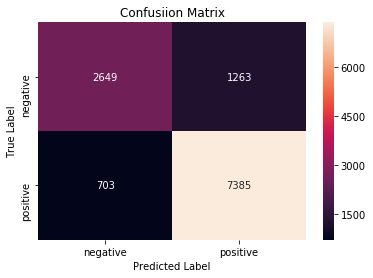

In [0]:
cm = confusion_matrix(Y_test_data ,prediction2)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
models_performence1['Model'].append('Logistic Regression')
models_performence1['Vectorizer'].append('BOW')
models_performence1['SearchCV'].append(SearchCV)
models_performence1['Best penalty'].append(best_panalty)
models_performence1[ 'Optimal lambda'].append(lambda_new)
models_performence1['Training error'].append(training_error*100)
models_performence1[ 'Test error'].append(Testing_error*100)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [0]:
columns = ["Model","Vectorizer","SearchCV", "Best penalty","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df3=pd.DataFrame(models_performence1, columns=columns)

In [0]:

result_display(df3)

|       Model       |Vectorizer|   SearchCV   |Best penalty|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------------|----------|--------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Logistic Regression|BoW       |GridSearchCV  |l2          |        1.0000|      0.005037|     20.46|  0.7954|76.53| 76.32|    76.76|
|Logistic Regression|BOW       |RandomsearchCV|l2          |        0.0036|      0.986776|     16.38|  0.8362|80.59| 79.51|    82.21|


# 2. tf-idf

TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf.

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

In [0]:
models_performence = {
    'Model':[],
    'Vectorizer': [],
    'SearchCV':[],
    'Scoring Metrics': [],
    'Train_model_score': [],
    'Test_model_score': [],
    'best panalty': [],
    'Best lambda':[],
}

columns = ["Model","Vectorizer","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
pd.DataFrame(models_performence, columns=columns)

,Model,Vectorizer,SearchCV,Scoring Metrics,Train_model_score,Test_model_score,best panalty,Best lambda


In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train_data.values.astype('U').ravel())
final_tf_idf.get_shape()

(28000, 588331)

In [0]:

features = tf_idf_vect.get_feature_names()
len(features)

588331

In [0]:
final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tf_idf )

## tf-idf For Testing datasets

In [0]:
final_tf_idf_test = tf_idf_vect.transform(X_test_data.values.astype('U').ravel())
final_tf_idf_test.get_shape()

(12000, 588331)

In [0]:
final_tfidf_np_test = StandardScaler(with_mean=False).fit_transform(final_tf_idf_test )

In [0]:
vectorization='TF-IDF'
optimal_lambda = lambda_LR1(final_tfidf_np ,Train_data,final_tfidf_np_test,Y_test_data,vectorization)

In [0]:
columns = ["Model","Vectorizer","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
df6=pd.DataFrame(models_performence, columns=columns)

In [0]:
result_display(df6)

|       Model       |Vectorizer|   SearchCV   |Scoring Metrics|Train_model_score|Test_model_score|best panalty|Best lambda|
|-------------------|----------|--------------|---------------|----------------:|---------------:|------------|----------:|
|Logistic Regression|TF-IDF    |GridSearchCV  |accuracy       |           0.9989|          0.7872|l2          |   3593.814|
|Logistic Regression|TF-IDF    |RandomsearchCV|accuracy       |           0.9989|          0.7765|l2          |      0.100|
|Logistic Regression|TF-IDF    |GridSearchCV  |precision      |           0.9985|          0.7671|l2          |   3593.814|
|Logistic Regression|TF-IDF    |RandomsearchCV|precision      |           0.9984|          0.7629|l2          |      3.768|
|Logistic Regression|TF-IDF    |GridSearchCV  |recall         |           1.0000|          0.9852|l2          |      1.000|
|Logistic Regression|TF-IDF    |RandomsearchCV|recall         |           1.0000|          0.9858|l2          |      1.267|
|Logisti

## RandomsearchCV with L2 regularization (Tf-IDf)

In [0]:
#L2 regularization

zx=df6[df6['best panalty'] == 'l2']
zx=df6[df6['Vectorizer'] == 'TF-IDF']

zx=zx[zx['SearchCV']=='RandomsearchCV']

zx= zx.ix[zx['Test_model_score'].idxmax()]
print(zx)
lambdax=zx['Best lambda']

best_panalty=zx['best panalty']

Scoring_Metrics =zx['Scoring Metrics']
SearchCV=zx['SearchCV']

Model                Logistic Regression
Vectorizer                        TF-IDF
SearchCV                  RandomsearchCV
Scoring Metrics                   recall
Train_model_score                      1
Test_model_score                0.985781
best panalty                          l2
Best lambda                      1.26738
Name: 5, dtype: object


In [0]:
#Best lambda and best penalty
C1 = uniform(loc=0, scale=lambdax)
hp5=dict(C=C1, penalty=[best_panalty])
LR5 =RandomizedSearchCV(LogisticRegression(), hp5, scoring =Scoring_Metrics, cv=tscv)
LR5.fit(final_data ,Train_data)

prediction5 = LR5.predict(final_data_test)
lambda_new=LR5.best_params_['C']

In [0]:
#Training accuracy and training error
training_score=LR5.score(final_data,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.999949634852682
training error is = 5.036514731804331e-05


In [0]:
# Testing Accuracy and testing error for knn model

Testing_score=round(accuracy_score(Y_test_data ,prediction5),5)
print("Accuracy for Logistic Regression model with TF_IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Logistic Regression model with TFIDF is = ",Testing_error)

Accuracy for Logistic Regression model with Avg word2vec is =  0.79958
Testing error for Logistic Regression model with Avg word2vec is =  0.20042000000000004


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction5,average='macro'),5)*100
recall = round(recall_score(Y_test_data,prediction5,average='macro'),5)*100
precision = round(precision_score(Y_test_data ,prediction5,average='macro'),5)*100

In [0]:
print(classification_report( Y_test_data,prediction5))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      3912
           1       0.84      0.86      0.85      8088

    accuracy                           0.80     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.80      0.80      0.80     12000



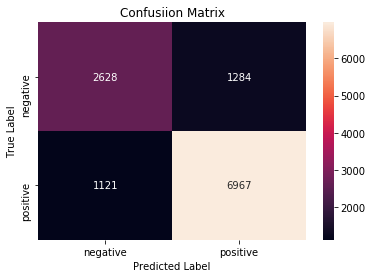

In [0]:
cm = confusion_matrix(Y_test_data ,prediction5)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
models_performence1['Model'].append('Logistic Regression')
models_performence1['Vectorizer'].append('TF-IDF')
models_performence1['SearchCV'].append(SearchCV)
models_performence1['Best penalty'].append(best_panalty)
models_performence1[ 'Optimal lambda'].append(lambda_new)
models_performence1['Training error'].append(training_error*100)
models_performence1[ 'Test error'].append(Testing_error*100)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [0]:
columns = ["Model","Vectorizer","SearchCV", "Best penalty","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df7=pd.DataFrame(models_performence1, columns=columns)

In [0]:
result_display(df7)

|       Model       |Vectorizer|   SearchCV   |Best penalty|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------------|----------|--------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Logistic Regression|BoW       |GridSearchCV  |l2          |       1.00000|      0.005037|     20.46|  0.7954|76.53| 76.32|    76.76|
|Logistic Regression|BOW       |RandomsearchCV|l2          |       0.00356|      0.986776|     16.38|  0.8362|80.59| 79.51|    82.21|
|Logistic Regression|TF-IDF    |RandomsearchCV|l2          |       0.42450|      0.005037|     20.04|  0.7996|76.94| 76.66|    77.27|


# GridSearchCV with L2 regularization (Tf-IDf)

In [0]:
zx=df[df['best panalty'] == 'l2']
zx=zx[zx['SearchCV']=='GridSearchCV']
zx= zx.ix[zx['Test_model_score'].idxmax()]
print(zx)
lambdax=zx['Best lambda']

best_panalty=zx['best panalty']

Scoring_Metrics =zx['Scoring Metrics']
SearchCV=zx['SearchCV']

Model                Logistic Regression
Vectorizer                           BOW
SearchCV                    GridSearchCV
Scoring Metrics                   recall
Train_model_score                0.99995
Test_model_score                0.855836
best panalty                          l2
Best lambda                            1
Name: 4, dtype: object


In [0]:
#Best lambda and best penalty
hp6=dict(C=[lambdax], penalty=[best_panalty])
LR6 =GridSearchCV(LogisticRegression(), hp6, scoring =Scoring_Metrics, cv=tscv)

LR6 .fit(final_tfidf_np ,Train_data)

prediction6 = LR6.predict(final_tfidf_np_test)

In [0]:
#Training accuracy and training error
training_score=LR6.score(final_tfidf_np,Train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 1.0
training error is = 0.0


In [0]:
# Testing Accuracy and testing error for knn model

Testing_score=round(accuracy_score(Y_test_data ,prediction6),5)
print("Accuracy for Logistic Regression model with Avg word2vec is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Logistic Regression model with Avg word2vec is = ",Testing_error)

Accuracy for Logistic Regression model with Avg word2vec is =  0.781
Testing error for Logistic Regression model with Avg word2vec is =  0.21899999999999997


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction6,average='macro'),5)*100
recall = round(recall_score(Y_test_data,prediction6,average='macro'),5)*100
precision = round(precision_score(Y_test_data ,prediction6,average='macro'),5)*100

In [0]:
print(classification_report( Y_test_data,prediction6))

              precision    recall  f1-score   support

           0       0.92      0.36      0.52      3912
           1       0.76      0.99      0.86      8088

    accuracy                           0.78     12000
   macro avg       0.84      0.67      0.69     12000
weighted avg       0.81      0.78      0.75     12000



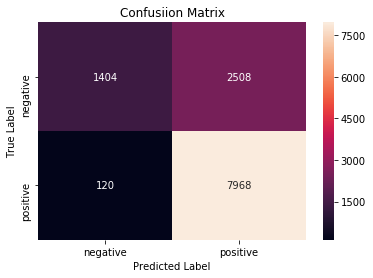

In [0]:
cm = confusion_matrix(Y_test_data ,prediction6)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:

models_performence1['Model'].append('Logistic Regression')
models_performence1['Vectorizer'].append('TF-IDF')
models_performence1['SearchCV'].append(SearchCV)
models_performence1['Best penalty'].append(best_panalty)
models_performence1[ 'Optimal lambda'].append(lambdax)
models_performence1['Training error'].append(training_error*100)
models_performence1[ 'Test error'].append(Testing_error*100)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [0]:
columns = ["Model","Vectorizer","SearchCV", "Best penalty","Optimal lambda", "Training error",  "Test error",
            "Accuracy","F1","recall","precision",
          ]
df8=pd.DataFrame(models_performence1, columns=columns)

In [0]:
result_display(df8)

|       Model       |Vectorizer|   SearchCV   |Best penalty|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------------|----------|--------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Logistic Regression|BoW       |GridSearchCV  |l2          |        1.0000|       0.00504|     20.46|  0.7954|76.53| 76.32|    76.76|
|Logistic Regression|BOW       |RandomsearchCV|l2          |        0.0036|       0.98678|     16.38|  0.8362|80.59| 79.51|    82.21|
|Logistic Regression|TF-IDF    |RandomsearchCV|l2          |        0.4245|       0.00504|     20.04|  0.7996|76.94| 76.66|    77.27|
|Logistic Regression|TF-IDF    |GridSearchCV  |l2          |        1.0000|       0.00000|     21.90|  0.7810|68.75| 67.20|    84.09|


# Feature Importance for Logistic Regression

Feature importance using count_vect

In [0]:
model = LogisticRegression( random_state=0, class_weight='balanced')
model.fit(final_data ,Train_data)
# Calculate feature importances
count_vect_feature=count_vect.get_feature_names()
feature_importance = model.coef_[0]
print(feature_importance)

[ 1.34850583e-05  2.12334911e-02  4.54989378e-02 ...  5.66638090e-03
 -2.68272436e-02  5.13767174e-03]


In [0]:
print('pedfjhlfiuvhb oif')

In [0]:
Negative_Feature_Importance= feature_importance[-15:]
print('Negative_Feature_Importanc',Negative_Feature_Importance)
Positive_Feature_Importance= feature_importance[:15]
print('Positive_Feature_Importance',Positive_Feature_Importance)

Negative_Feature_Importanc [-2.38849349e-03  6.36523288e-02  7.06145883e-02 -9.79521208e-06
 -2.21460169e-03 -5.39698826e-02  2.23220092e-02 -1.71223374e-03
  3.69909964e-03  2.89111488e-03 -1.40873524e-02  2.22307962e-02
  5.66638090e-03 -2.68272436e-02  5.13767174e-03]
Positive_Feature_Importance [ 1.34850583e-05  2.12334911e-02  4.54989378e-02 -3.38668519e-02
  1.89187868e-03 -1.65036748e-05  1.16330774e-03 -8.56089222e-03
 -4.84473679e-07 -9.54025670e-03  1.85752648e-02  1.88811311e-02
  4.19564773e-05  4.57073409e-02 -8.24479311e-02]


Top 15 negative class feature bags             -0.667271
china            -0.669418
tasteless        -0.708559
hard             -0.716983
terrible         -0.719146
waste            -0.723541
chances          -0.740610
canidae          -0.747253
disgusting       -0.771746
changed          -0.778886
disappointment   -0.840783
awful            -0.871476
wasabi           -0.961707
worst            -1.288986
not              -2.580417
dtype: float64


Text(0, 0.5, 'Relative Feature Importance for Negative class ')

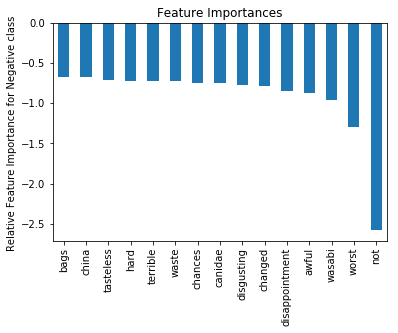

In [0]:
# Relative Feature Importance for Negative class using BOW
feat_imp = pd.Series(feature_importance, count_vect_feature).sort_values(ascending=False)
print("Top 15 negative class feature",feat_imp[-15:])

feat_imp[-15:].plot(kind='bar', title='Feature Importances')
plt.ylabel('Relative Feature Importance for Negative class ')

Top 15 postive class feature great        2.221863
love         1.618043
best         1.585839
good         1.331281
perfect      1.296185
excellent    1.088919
awesome      0.986986
find         0.962300
loves        0.956074
favorite     0.920897
big          0.919618
wonderful    0.864899
keeps        0.845408
day          0.772127
tasty        0.761375
dtype: float64


Text(0, 0.5, 'Relative Feature Importance for Postive class ')

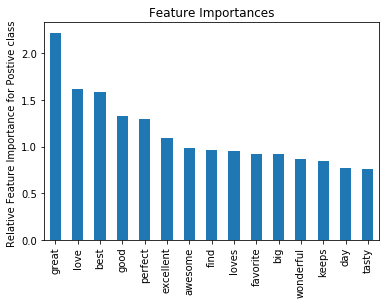

In [0]:
#Feature Importances for postive class using count_vect

feat_imp = pd.Series(feature_importance, count_vect_feature).sort_values(ascending=False)
print("Top 15 postive class feature",feat_imp[:15])

feat_imp[:15].plot(kind='bar', title='Feature Importances')
plt.ylabel('Relative Feature Importance for Postive class ')

## Feature importance using tf-idf -vect

In [0]:
model = LogisticRegression(random_state=0, class_weight='balanced')
model.fit(final_tfidf_np ,Train_data)
tf_idf_feature=tf_idf_vect .get_feature_names()
feature_importance = model.coef_[0]
print(feature_importance)

[-0.00117937 -0.00117937  0.00895425 ... -0.00228546  0.00212026
  0.00212026]


In [0]:
Negative_Feature_Importance= feature_importance[-15:]
print('Negative_Feature_Importance',Negative_Feature_Importance)
Positive_Feature_Importance= feature_importance[:15]
print('Positive_Feature_Importance',Positive_Feature_Importance)

Negative_Feature_Importance [ 0.00060386 -0.00204838  0.00123329  0.00073668 -0.00278928  0.00145433
  0.00145433  0.00280928 -0.00807861  0.00059899  0.00059899 -0.00228546
 -0.00228546  0.00212026  0.00212026]
Positive_Feature_Importance [-0.00117937 -0.00117937  0.00895425  0.00846983 -0.00482771  0.00224052
  0.00122223  0.00122223  0.00511049  0.00050238  0.00174772  0.00499374
 -0.00135697 -0.00135697  0.00122572]


Top 15 negative class feature waste             -0.054711
store per         -0.055142
huge fan          -0.056453
terrible          -0.056777
awful             -0.056964
stale             -0.057962
not buy           -0.058493
not good          -0.058929
disappointed      -0.060368
would not         -0.061756
family addicted   -0.062578
not recommend     -0.063263
worst             -0.065517
not               -0.069689
not worth         -0.090077
dtype: float64


Text(0, 0.5, 'Relative Feature Importance for Negative class ')

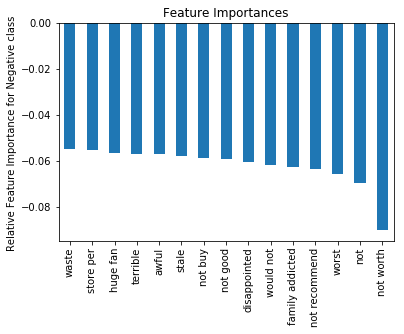

In [0]:
# Relative Feature Importance for Negative class using tf_idf
feat_imp = pd.Series(feature_importance,tf_idf_feature).sort_values(ascending=False)
print("Top 15 negative class feature",feat_imp[-15:])

feat_imp[-15:].plot(kind='bar', title='Feature Importances')
plt.ylabel('Relative Feature Importance for Negative class ')

Top 15 postive class feature great        0.185766
best         0.137842
love         0.128978
good         0.127050
use          0.113502
excellent    0.110492
try          0.097685
delicious    0.095287
loves        0.085545
find         0.083188
favorite     0.079197
perfect      0.074291
wonderful    0.072561
tasty        0.070412
highly       0.066057
dtype: float64


Text(0, 0.5, 'Relative Feature Importance for Postive class ')

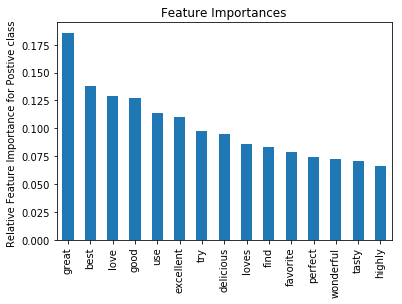

In [0]:
#Feature Importances for postive class using tf_idf

feat_imp = pd.Series(feature_importance, tf_idf_feature).sort_values(ascending=False)
print("Top 15 postive class feature",feat_imp[:15])

feat_imp[:15].plot(kind='bar', title='Feature Importances')
plt.ylabel('Relative Feature Importance for Postive class ')

### Observations
Feature Importance for logistic regression using BOW and TF-IDF is as above.
Top 15 features for postive words and negative words are printed.
Graph is based on features weight vs relative feature importance.
Top 15 Important Negative words which determines point belongs to negative class and Top 15 Important positive words which determines point belongs to positive class shows importance of words.



#### Use of Pertubation Techniques for postive class and negative class using tf-idf -vect

Weight vector with pertubation [5.000000e-01 1.500000e+00 2.500000e+00 ... 5.883285e+05 5.883295e+05
 5.883305e+05]
original Weight vector [-0.63486601 -0.63486601  4.82017151 ... -1.23028842  1.14136122
  1.14136122]
Difference between w and w` [ -1.13486601  -2.13486601   2.32017151   1.05940354  -7.09880868
  -4.293906    -5.84206018  -6.84206018  -5.74896811  -9.22956109
  -9.55918403  -8.81181377 -13.2304727  -14.2304727  -13.84018056
 -15.62816899 -16.62816899 -16.19230776 -17.19230776 -17.62115321]


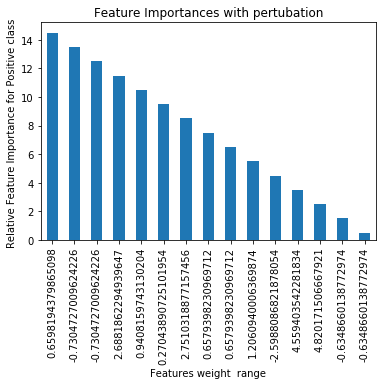

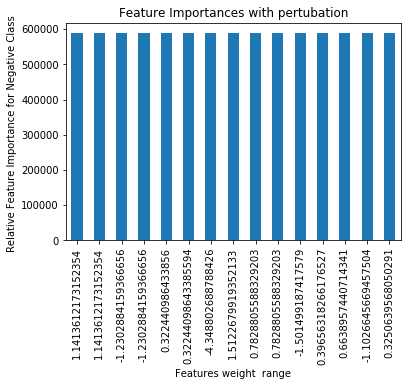

In [0]:
# Use of Pertubation Techniques for postive class and negative class using tf-idf -vect
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# feature_importance# w

pos = np.arange(feature_importance.shape[0]) + .5  # 0.5 is pertubation  w`
# pos is after adding small noise in weight
print('Weight vector with pertubation',pos)
print('original Weight vector',feature_importance)


yy = [float(i) for i in feature_importance] #w

#print(yy)
vc=yy -pos
print('Difference between w and w`',vc[:20])

Pertub_pos = pd.Series(pos[:15],feature_importance[:15]).sort_values(ascending=False)
Pertub_pos.plot(kind='bar', title='Feature Importances with pertubation')
plt.xlabel('Features weight  range')
plt.ylabel('Relative Feature Importance for Positive class ')
plt.show()

Pertub_neg = pd.Series(pos[-15:],feature_importance[-15:]).sort_values(ascending=False)
Pertub_neg.plot(kind='bar', title='Feature Importances with pertubation')
plt.xlabel('Features weight  range')
plt.ylabel('Relative Feature Importance for Negative Class ')
plt.show()

## Pertubation
* Pertubation Techniques for positive features and Negative features are used to check collinearity of features.
* If weight vector of features can change arbitrarily ,It means weight vector can not be used as feature Importance .
* Here,If Original weight vector and pertubated weight vector for respective features differ significantly,then we can't use weight vector (respective feature) for feature importance in particular class.
* In Feature Importance for positive class,[ "great" ,"love","and"] has high importance while ["are","love this","my"] has low importance and In pertubated Feature Importance, ["are" ,"my"] has low importance. This means that we can remove it's Importance from Positive class.
* Here,if positive feature or negative feature (words) are pertubated,then we can check whether a particular feature is important or not.
* All features are highly important in negative class. Also for pertubated Feature Importance ,all negative features are highly important so Feature .
* Importance for negative class doesn't change with small change in weight vector value.
* Finally,it is concluded that negative Feature Importance are highly important while positive Feature Importance are not

# Conclusion

|       Model       |Vectorizer|   SearchCV   |Best penalty|Optimal lambda|Training error|Test error|Accuracy| F1  |recall|precision|
|-------------------|----------|--------------|------------|-------------:|-------------:|---------:|-------:|----:|-----:|--------:|
|Logistic Regression|BoW       |GridSearchCV  |l2          |        1.0000|       0.00504|     20.46|  0.7954|76.53| 76.32|    76.76|
|Logistic Regression|BOW       |RandomsearchCV|l2          |        0.0036|       0.98678|     16.38|  0.8362|80.59| 79.51|    82.21|
|Logistic Regression|TF-IDF    |RandomsearchCV|l2          |        0.4245|       0.00504|     20.04|  0.7996|76.94| 76.66|    77.27|
|Logistic Regression|TF-IDF    |GridSearchCV  |l2          |        1.0000|       0.00000|     21.90|  0.7810|68.75| 67.20|    84.09|

* Above Table shows the performance of trained and tested model with Logistic Regression.
* Confusion matrix and scoring metrics values for TF-IDF with RandomSearch CV & L1 regularization is comparatively best with other trained model.
* After comparing the developed models, Logistic Regression model with TF-IDF with RandomsearchCV ,l1 regularization works the best to predict the polarity of reviews among all models.